In [33]:
import os
import math
from PIL import Image
from config import BASE_DIR
import numpy as np
import matplotlib.pyplot as plt
from src.ml.scripts.predict import predict

image = Image.open(os.path.join(BASE_DIR, 'data/satellite_images/ld.tif'))

tile_size = 50

image_size = list(map(lambda x : math.floor(x / 50), image.size))

tiles = np.empty(image_size, dtype=object)

for i in range(0, tiles.shape[0]):
    for j in range(0, tiles.shape[1]):
        x = i * tile_size
        y = j * tile_size
        tile = image.crop((x, y, x + tile_size, y + tile_size))
        tiles[i, j] = np.array(tile)

predictions = predict('model1', tiles.flatten())

pred_map = np.array(predictions).reshape(image_size)

Using cache found in /home/witek/.cache/torch/hub/pytorch_vision_v0.10.0
/home/witek/anaconda3/envs/main/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/witek/anaconda3/envs/main/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:

for i in range(0, pred_map.shape[0]):
    for j in range(0, pred_map.shape[1]):
        x = i * tile_size
        y = j * tile_size

        if pred_map[i, j]:
            region = image.crop((x, y, x + tile_size, y + tile_size))
            red_channel = region.split()[0]
            red_channel = red_channel.point(lambda p: p * 1.5)
            new_region = Image.merge("RGB", (red_channel, region.split()[1], region.split()[2]))
            image.paste(new_region, (x, y, x + tile_size, y + tile_size))

image.show()

/tmp/ipykernel_10044/1928208568.py:3: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  pred_map, clusters = measurements.label(pred_map)


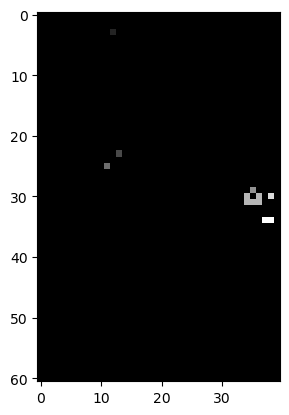

In [35]:
from scipy.ndimage import measurements

pred_map, clusters = measurements.label(pred_map)
plt.imshow(pred_map * 10, cmap='gray')

In [36]:
clusters_to_filter = [cluster for cluster in np.unique(pred_map) if np.count_nonzero(pred_map == cluster) == 1]
mask = np.isin(pred_map, clusters_to_filter)
pred_map[mask] = 0

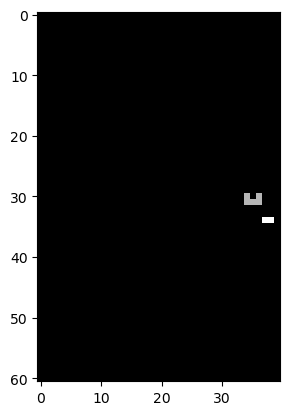

In [37]:
plt.imshow(pred_map, cmap='gray')